In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import random
from datetime import datetime
from math import nan
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import statsmodels.api as sm

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

In [3]:
sns.set_style("whitegrid")

### 1. Import and clean data preliminarily

In [4]:
matches_combined = pd.read_csv('../dataset/matches_combines_2.csv')
matches = pd.read_csv('../dataset/matches.csv')
player = pd.read_csv('../dataset/player.csv')
player_detail = pd.read_csv('../dataset/player_detail.csv')

In [5]:
matches_combined.shape

(21361, 74)

In [6]:
matches_combined.head()

,match_api_id,dribbling_CB_home,dribbling_GK_home,dribbling_MF_home,dribbling_SB_home,dribbling_ST_home,dribbling_W_home,sprint_speed_CB_home,sprint_speed_GK_home,sprint_speed_MF_home,sprint_speed_SB_home,sprint_speed_ST_home,sprint_speed_W_home,passing_CB_home,passing_GK_home,passing_MF_home,passing_SB_home,passing_ST_home,passing_W_home,shooting_CB_home,shooting_GK_home,shooting_MF_home,shooting_SB_home,shooting_ST_home,shooting_W_home,defence_CB_home,defence_GK_home,defence_MF_home,defence_SB_home,defence_ST_home,defence_W_home,goalkeeping_CB_home,goalkeeping_GK_home,goalkeeping_MF_home,goalkeeping_SB_home,goalkeeping_ST_home,goalkeeping_W_home,dribbling_CB_away,dribbling_GK_away,dribbling_MF_away,dribbling_SB_away,dribbling_ST_away,dribbling_W_away,sprint_speed_CB_away,sprint_speed_GK_away,sprint_speed_MF_away,sprint_speed_SB_away,sprint_speed_ST_away,sprint_speed_W_away,passing_CB_away,passing_GK_away,passing_MF_away,passing_SB_away,passing_ST_away,passing_W_away,shooting_CB_away,shooting_GK_away,shooting_MF_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_GK_away,defence_MF_away,defence_SB_away,defence_ST_away,defence_W_away,goalkeeping_CB_away,goalkeeping_GK_away,goalkeeping_MF_away,goalkeeping_SB_away,goalkeeping_ST_away,goalkeeping_W_away,result
0,483130,51.0,21.0,73.50,51.0,74.5,68.0,72.0,67.0,74.50,76.5,78.5,71.5,59.67,41.33,78.00,62.67,64.17,74.33,53.50,19.8,74.30,60.3,65.7,70.70,77.62,29.50,66.62,81.50,49.38,78.88,27.8,81.0,31.10,28.3,26.4,30.4,33.5,25.0,55.50,60.50,65.5,66.0,63.0,44.0,72.50,73.5,67.0,76.00,51.67,44.67,73.00,67.33,53.17,71.00,48.2,25.0,55.30,51.9,64.0,68.3,69.42,33.75,70.75,64.50,36.71,61.75,25.7,73.0,29.30,26.40,22.9,26.0,win
1,483131,36.5,22.0,63.50,26.0,57.5,62.0,61.0,34.0,70.00,51.0,70.5,62.0,53.17,38.33,63.17,43.33,57.67,64.75,42.70,22.0,46.90,40.7,68.0,63.35,64.50,30.33,45.42,59.12,48.12,55.81,23.1,72.2,26.20,16.5,19.0,19.0,42.5,21.0,54.00,48.00,61.0,65.5,61.0,21.0,77.00,73.0,73.0,68.75,63.83,37.33,59.00,61.33,49.33,59.50,57.2,19.2,52.60,61.3,71.0,60.1,69.50,18.75,66.50,63.62,32.50,34.12,28.9,69.4,25.33,28.60,19.2,25.7,win
2,483133,58.0,22.0,75.67,60.5,88.0,78.5,77.0,24.0,71.33,78.0,85.0,78.0,71.00,41.00,76.00,77.33,68.67,79.17,57.70,22.4,72.40,67.1,81.4,67.80,75.31,19.75,57.42,74.38,42.75,67.00,30.9,81.4,22.93,26.0,22.4,30.4,51.5,22.0,66.00,45.50,47.0,67.0,66.5,32.0,69.33,67.5,66.0,73.00,68.67,38.67,66.89,60.50,54.00,59.33,59.7,21.0,61.73,46.7,38.2,67.4,72.25,31.50,60.33,70.50,63.50,33.62,28.1,74.6,26.93,26.80,22.0,25.3,win
3,483134,35.5,44.0,79.00,33.0,67.5,36.0,66.5,63.0,75.50,38.0,73.5,68.0,51.67,66.67,68.17,53.17,62.00,63.67,49.35,41.8,60.30,34.6,66.5,48.60,71.50,65.75,35.38,51.88,37.38,68.50,26.0,27.0,17.50,41.9,25.3,28.4,51.0,21.0,78.50,68.25,66.0,69.0,68.0,48.0,74.00,77.0,81.0,74.50,53.17,40.33,77.67,71.25,56.33,74.50,43.3,18.4,62.40,65.2,64.9,53.9,71.88,24.50,68.88,74.50,28.25,65.38,23.7,80.4,30.00,28.75,16.5,28.9,win
4,483135,55.0,22.0,62.33,42.5,57.0,76.5,75.0,52.0,71.67,64.0,64.0,78.5,71.00,38.33,64.78,49.33,48.00,69.50,49.90,19.2,57.47,49.8,61.4,71.30,80.38,29.00,62.75,47.75,39.75,40.50,29.5,77.6,28.67,23.2,23.0,25.0,53.0,22.0,71.33,61.00,75.0,66.5,69.5,57.0,80.00,80.5,84.0,69.50,65.00,37.00,74.78,70.50,65.67,63.83,52.9,19.2,69.93,61.2,65.2,67.1,77.50,29.25,66.92,72.62,37.75,60.38,28.8,67.2,29.40,28.60,26.2,28.3,tie


In [7]:
matches_combined['result'].value_counts()

win     9804
lose    6161
tie     5396
Name: result, dtype: int64

- Home win has more observations than home lose

In [8]:
#drop columns that have less significant influence on match result by common sense
columns = matches_combined.columns
new_columns = [col for col in columns if 'dribbling_GK' not in col
                                  and 'sprint_speed_GK' not in col
                                  and 'passing_speed_GK' not in col
                                  and 'shooting_GK' not in col 
                                  and 'defence_GK' not in col
                                  and 'passing_GK' not in col
                                  and 'dribbling_CB' not in col
                                  and 'sprint_speed_CB' not in col
                                  and 'passing_speed_CB' not in col
                                  and 'shooting_CB' not in col   
                                  and 'defence_ST' not in col
                                  and 'defence_W' not in col
                                  and 'sprint_speed_MF' not in col
                                  and 'goalkeeping_CB' not in col
                                  and 'goalkeeping_MF' not in col
                                  and 'goalkeeping_SB' not in col
                                  and 'goalkeeping_ST' not in col
                                  and 'goalkeeping_W' not in col]

matches_combined = matches_combined[new_columns]

In [9]:
matches_combined.isna().sum()

match_api_id              0
dribbling_MF_home         0
dribbling_SB_home      1303
dribbling_ST_home         0
dribbling_W_home       1859
                       ... 
defence_CB_away           0
defence_MF_away           0
defence_SB_away        1339
goalkeeping_GK_away       0
result                    0
Length: 42, dtype: int64

- Missing data appear on position 'W' and 'SB'.

In [10]:
matches_combined.dropna(inplace = True)
matches_combined = matches_combined.reset_index(drop = True)
matches_combined.shape

(16318, 42)

### 2. Check out outliers

In [11]:
matches_new = matches_combined.drop('match_api_id', axis = 1)
y = matches_new['result']
X = matches_new.drop(['result'], axis = 1)

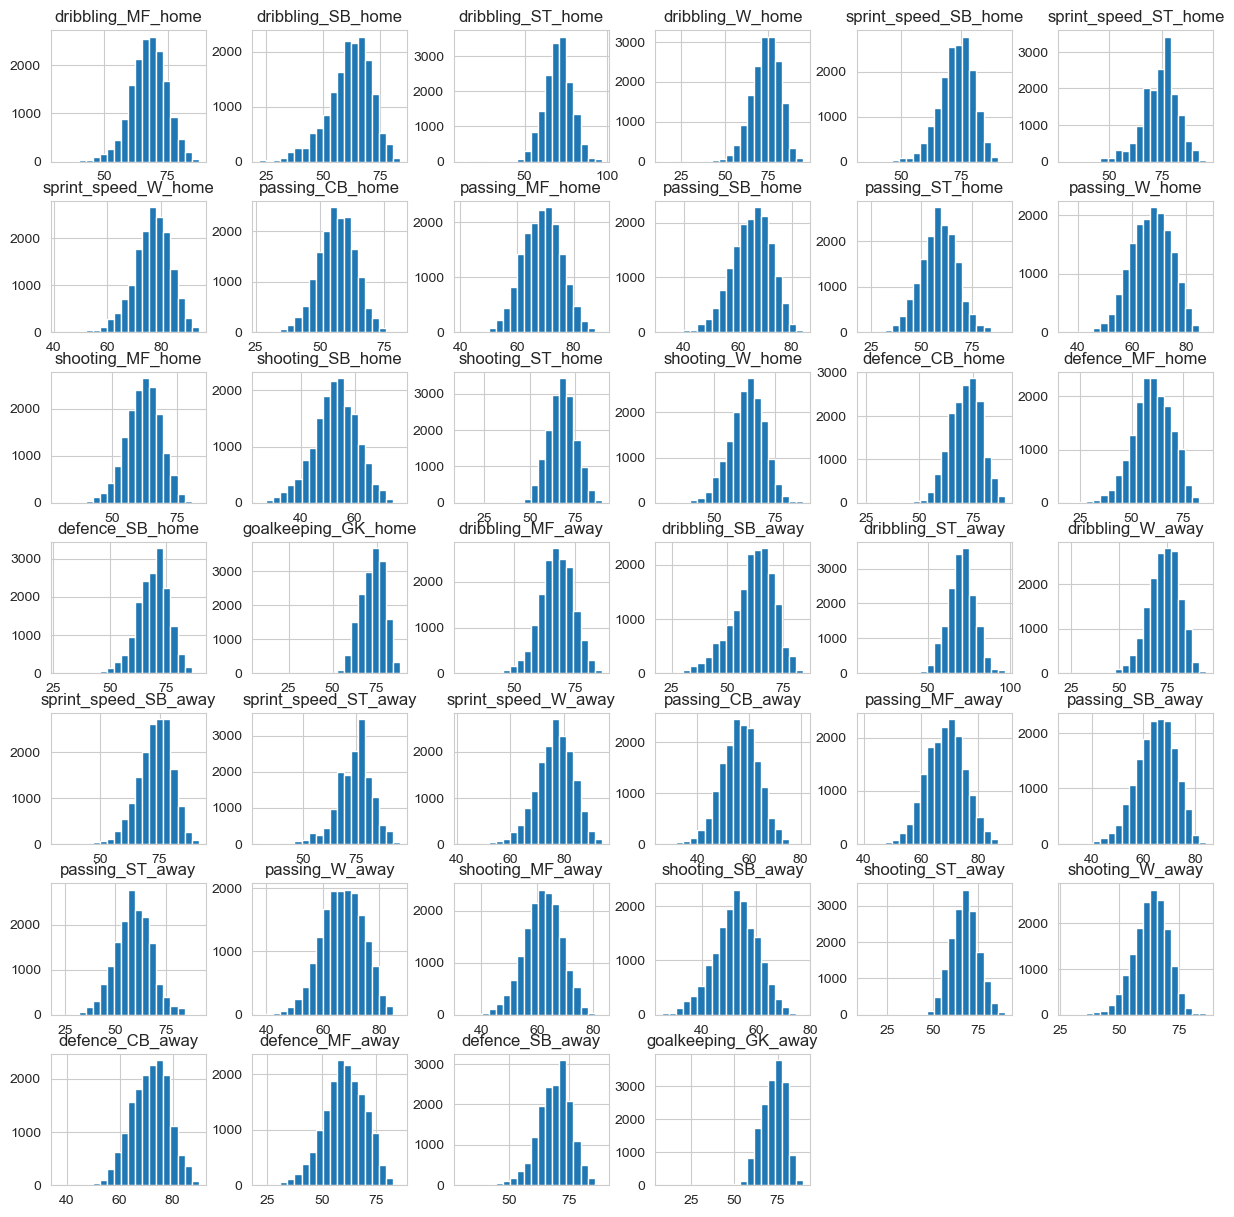

In [12]:
# A quick view of all columns distributions
X.hist(bins=20, figsize=(15, 15))
plt.show()

In [13]:
X.describe()

,dribbling_MF_home,dribbling_SB_home,dribbling_ST_home,dribbling_W_home,sprint_speed_SB_home,sprint_speed_ST_home,sprint_speed_W_home,passing_CB_home,passing_MF_home,passing_SB_home,passing_ST_home,passing_W_home,shooting_MF_home,shooting_SB_home,shooting_ST_home,shooting_W_home,defence_CB_home,defence_MF_home,defence_SB_home,goalkeeping_GK_home,dribbling_MF_away,dribbling_SB_away,dribbling_ST_away,dribbling_W_away,sprint_speed_SB_away,sprint_speed_ST_away,sprint_speed_W_away,passing_CB_away,passing_MF_away,passing_SB_away,passing_ST_away,passing_W_away,shooting_MF_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_MF_away,defence_SB_away,goalkeeping_GK_away
count,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000
mean,67.560697,61.571528,70.430775,73.550240,73.172728,73.904748,76.842799,56.412529,68.881730,65.002079,58.732193,66.940392,62.064441,52.808854,67.729714,63.419980,71.513941,60.042614,69.032452,72.499578,67.362694,61.338581,70.552265,73.169771,73.107166,74.107624,76.655375,56.452500,68.738788,64.808830,58.870531,66.885085,61.922917,52.616795,67.598510,63.190685,71.515799,60.250490,69.023489,72.503704
std,6.985523,9.591850,8.240265,8.111856,7.149714,8.572796,6.822024,7.153408,6.759645,7.346609,8.929718,7.400428,6.692125,8.034900,7.439176,7.097252,7.192360,9.357865,6.931232,6.741849,6.949556,9.610680,8.203939,8.213308,7.188506,8.526927,6.897760,7.134002,6.696433,7.401987,8.943650,7.358035,6.660948,7.982947,7.494589,7.204879,7.150448,9.422714,6.933329,6.784507
min,32.000000,22.000000,11.000000,14.000000,34.220000,29.200000,41.370000,26.460000,40.170000,31.920000,21.330000,35.250000,28.850000,24.700000,12.000000,29.000000,23.940000,17.620000,27.080000,8.330000,28.000000,20.750000,11.000000,22.000000,32.000000,29.200000,41.370000,26.460000,40.080000,29.830000,21.330000,37.500000,32.600000,25.400000,12.000000,27.200000,36.620000,21.250000,29.750000,8.200000
25%,63.170000,56.250000,65.000000,68.330000,69.000000,69.000000,72.750000,51.580000,64.170000,60.000000,52.870000,61.750000,57.710000,47.700000,62.800000,59.000000,66.500000,54.120000,64.652500,67.900000,63.000000,56.000000,65.322500,67.750000,68.750000,69.000000,72.500000,51.670000,64.000000,59.830000,53.000000,61.780000,57.530000,47.400000,62.600000,58.650000,66.500000,54.190000,64.620000,67.900000
50%,67.870000,62.620000,71.000000,74.050000,73.830000,75.000000,77.250000,56.500000,69.070000,65.500000,58.940000,67.170000,62.400000,53.100000,68.000000,63.900000,72.060000,60.210000,69.690000,73.300000,67.600000,62.500000,71.000000,73.750000,73.750000,75.000000,77.065000,56.555000,68.925000,65.280000,59.000000,67.080000,62.200000,52.900000,67.800000,63.700000,72.000000,60.500000,69.670000,73.300000
75%,72.250000,68.250000,75.750000,79.490000,78.250000,79.250000,81.500000,61.420000,73.570000,70.330000,64.830000,72.420000,66.700000,58.400000,72.600000,68.300000,76.750000,66.790000,73.750000,77.600000,72.170000,68.000000,75.750000,79.000000,78.027500,79.500000,81.500000,61.330000,73.330000,70.250000,64.920000,72.237500,66.550000,58.250000,72.600000,68.200000,76.690000,67.057500,73.750000,77.600000
max,87.170000,84.000000,97.000000,95.250000,93.500000,96.000000,94.200000,81.170000,89.920000,84.330000,91.330000,87.420000,83.470000,76.850000,89.700000,86.500000,89.880000,86.500000,89.250000,88.400000,86.000000,84.000000,97.000000,95.250000,91.500000,96.000000,94.200000,81.000000,89.330000,84.330000,91.330000,87.420000,83.000000,77.550000,89.700000,86.500000,89.880000,85.880000,88.690000,89

- A few parameters look way below average. 

In [14]:
z_scores = np.abs((X - X.mean()) / X.std())
outliers = z_scores > 4
outliers_rows = matches_combined[outliers.any(axis=1)]

outliers_rows.shape

(414, 42)

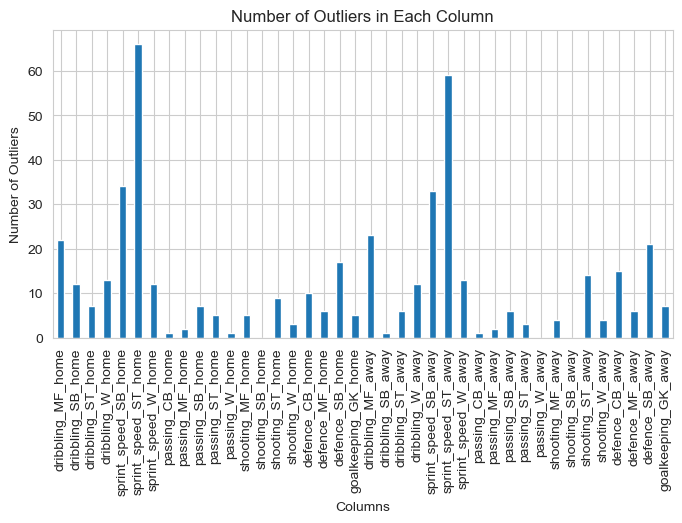

In [15]:
# Check which columns have the most outliers
outlier_counts = outliers.sum()
plt.figure(figsize=(8, 4))
outlier_counts.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers in Each Column')
plt.show()

In [16]:
outliers_rows.head(30)

,match_api_id,dribbling_MF_home,dribbling_SB_home,dribbling_ST_home,dribbling_W_home,sprint_speed_SB_home,sprint_speed_ST_home,sprint_speed_W_home,passing_CB_home,passing_MF_home,passing_SB_home,passing_ST_home,passing_W_home,shooting_MF_home,shooting_SB_home,shooting_ST_home,shooting_W_home,defence_CB_home,defence_MF_home,defence_SB_home,goalkeeping_GK_home,dribbling_MF_away,dribbling_SB_away,dribbling_ST_away,dribbling_W_away,sprint_speed_SB_away,sprint_speed_ST_away,sprint_speed_W_away,passing_CB_away,passing_MF_away,passing_SB_away,passing_ST_away,passing_W_away,shooting_MF_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_MF_away,defence_SB_away,goalkeeping_GK_away,result
3,483134,79.00,33.00,67.50,36.0,38.00,73.50,68.00,51.67,68.17,53.17,62.00,63.67,60.30,34.6,66.50,48.6,71.50,35.38,51.88,27.0,78.50,68.25,66.0,69.00,77.0,81.0,74.50,53.17,77.67,71.25,56.33,74.50,62.40,65.2,64.9,53.90,71.88,68.88,74.50,80.4,win
18,483154,61.00,23.00,67.50,69.0,65.50,73.50,76.50,64.33,70.00,55.17,62.00,71.50,53.90,36.7,66.50,62.0,70.42,45.12,72.00,72.2,58.00,52.00,64.0,74.00,69.5,82.0,75.50,51.67,71.67,63.83,75.33,63.33,61.93,45.5,63.4,68.60,69.42,63.17,68.00,73.0,tie
23,483161,71.33,30.00,76.00,80.5,63.00,75.00,77.50,67.17,74.78,47.83,73.67,79.00,69.93,30.9,64.40,63.8,74.88,66.92,52.75,24.6,77.50,35.50,74.0,73.50,73.5,81.0,77.50,66.00,80.00,55.50,72.17,71.17,79.30,51.1,73.6,66.70,77.00,67.00,77.75,81.0,win
82,483235,71.67,68.25,66.00,67.5,77.00,73.00,84.00,60.67,75.22,71.25,56.33,61.17,56.53,65.2,68.00,66.1,74.00,65.17,74.50,80.4,60.67,46.00,64.0,34.00,66.0,72.0,64.00,56.17,64.56,64.50,59.00,45.83,57.33,55.9,73.8,34.80,69.12,72.00,72.88,74.6,lose
111,483274,62.00,31.00,69.00,65.0,58.50,70.00,69.25,59.50,64.83,57.50,58.50,72.67,48.20,39.5,67.50,61.4,72.79,56.00,72.38,72.2,68.67,58.00,83.0,40.00,70.0,79.0,61.50,59.17,64.89,52.17,58.00,61.67,66.10,57.6,67.6,52.30,67.00,51.88,48.25,78.4,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,490052,71.50,23.00,61.00,66.5,60.00,71.00,68.00,41.00,67.67,48.83,48.00,64.50,55.20,35.6,54.90,46.8,60.58,47.25,59.38,61.4,63.00,47.00,64.5,65.00,63.0,66.0,68.00,63.67,60.17,58.33,59.17,67.50,51.10,41.0,60.3,56.60,63.62,56.12,68.46,62.4,tie
711,490086,33.50,57.50,70.50,67.0,64.00,70.50,76.00,45.00,48.83,68.67,56.67,61.50,38.30,45.0,64.10,50.8,67.75,59.62,65.25,62.6,75.00,53.00,57.5,22.00,59.5,69.0,52.00,39.00,69.00,51.17,49.67,45.67,53.10,38.8,54.1,39.20,60.96,49.75,60.12,61.4,win
713,490089,70.00,58.50,72.00,62.5,73.50,80.25,74.00,55.17,83.67,63.50,52.00,60.42,72.90,51.8,68.55,66.9,68.88,64.62,71.50,79.4,33.50,57.50,70.5,67.00,64.0,70.5,76.00,45.00,48.83,68.67,56.67,61.50,38.30,45.0,64.1,50.80,67.75,59.62,65.25,62.6,win
717,490094,67.50,38.50,73.50,37.5,68.00,71.00,52.00,41.00,68.33,45.50,62.33,49.33,51.50,34.2,57.00,41.4,60.58,57.25,59.38,61.4,63.00,39.00,65.5,56.25,65.0,69.5,66.25,57.67,59.67,53.83,36.50,55.08,47.30,29.4,61.1,57.75,69.04,44.62,67.38,69.8,win


In [17]:
# Check the match which shooting_ST_home = 12
matches.query('match_api_id == 483333')

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
4289,4903,4769,4769,2008/2009,21,2009,483333,8592,9746,2,0,1.0,2.0,4.0,6.0,8.0,1.0,3.0,5.0,7.0,9.0,5.0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,7.0,11.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,31293.0,25541.0,26138.0,40022.0,26052.0,33464.0,26112.0,24116.0,78185.0,40060.0,37254.0,41186.0,46645.0,39977.0,46447.0,26118.0,46650.0,46656.0,33108.0,26405.0,46660.0,94045.0


In [18]:
player.query('player_api_id == 37254')

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
6469,6478,37254,Mahamadou Samassa,177485,1986-05-01 00:00:00,187.96,185


In [19]:
player_detail.query('player_api_id == 37254')

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
107760,107761,177485,37254,2015,72.0,75.0,right,medium,medium,10.0,11.0,13.0,27.0,13.0,12.0,10.0,10.0,22.0,19.0,43.0,59.0,45.0,67.0,39.0,24.0,47.0,32.0,76.0,10.0,21.0,19.0,11.0,12.0,18.0,12.0,11.0,12.0,76.0,71.0,64.0,66.0,79.0
107761,107762,177485,37254,2014,70.0,73.0,right,medium,medium,25.0,25.0,25.0,26.0,25.0,25.0,25.0,25.0,21.0,25.0,43.0,59.0,45.0,64.0,39.0,23.0,47.0,32.0,90.0,25.0,20.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,75.0,69.0,63.0,62.0,78.0
107762,107763,177485,37254,2014,70.0,73.0,right,medium,medium,25.0,25.0,25.0,26.0,25.0,25.0,25.0,25.0,21.0,25.0,43.0,59.0,45.0,64.0,39.0,23.0,47.0,32.0,90.0,25.0,20.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,75.0,69.0,63.0,62.0,78.0
107763,107764,177485,37254,2014,65.0,65.0,right,medium,low,35.0,69.0,71.0,53.0,60.0,59.0,40.0,50.0,30.0,63.0,54.0,64.0,51.0,58.0,33.0,73.0,65.0,45.0,74.0,52.0,44.0,25.0,71.0,48.0,69.0,25.0,25.0,25.0,10.0,10.0,10.0,10.0,10.0
107764,107765,177485,37254,2014,65.0,70.0,right,medium,low,35.0,69.0,71.0,53.0,60.0,59.0,40.0,50.0,30.0,63.0,54.0,64.0,51.0,58.0,33.0,73.0,65.0,45.0,74.0,52.0,44.0,25.0,71.0,48.0,69.0,25.0,25.0,25.0,10.0,10.0,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107797,107798,190195,37254,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107798,107799,190195,37254,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107799,107800,190195,37254,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107800,107801,190195,37254,2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- It seems that this player had good days and bad days

In [20]:
# Check the match which goalkeeping_GK_home = 16.3
matches.query('match_api_id == 654326')

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
4630,5291,4769,4769,2009/2010,22,2010,654326,8682,9941,1,3,1.0,2.0,4.0,6.0,8.0,1.0,3.0,5.0,7.0,9.0,5.0,1.0,2.0,4.0,6.0,8.0,1.0,3.0,5.0,7.0,9.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,7.0,11.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,7.0,11.0,94289.0,107806.0,40680.0,26127.0,165583.0,39995.0,26057.0,25816.0,37466.0,40683.0,38363.0,26117.0,26399.0,26253.0,94549.0,26401.0,39105.0,179523.0,94550.0,40103.0,41365.0,38098.0


In [21]:
player.query('player_api_id == 94289')

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
4327,4331,94289,Idir Ouali,184927,1988-05-21 00:00:00,175.26,152


A quick search shows this player plays midfielder regularly instead of goalkeeper.

### 2. Check out correlations

<AxesSubplot:>

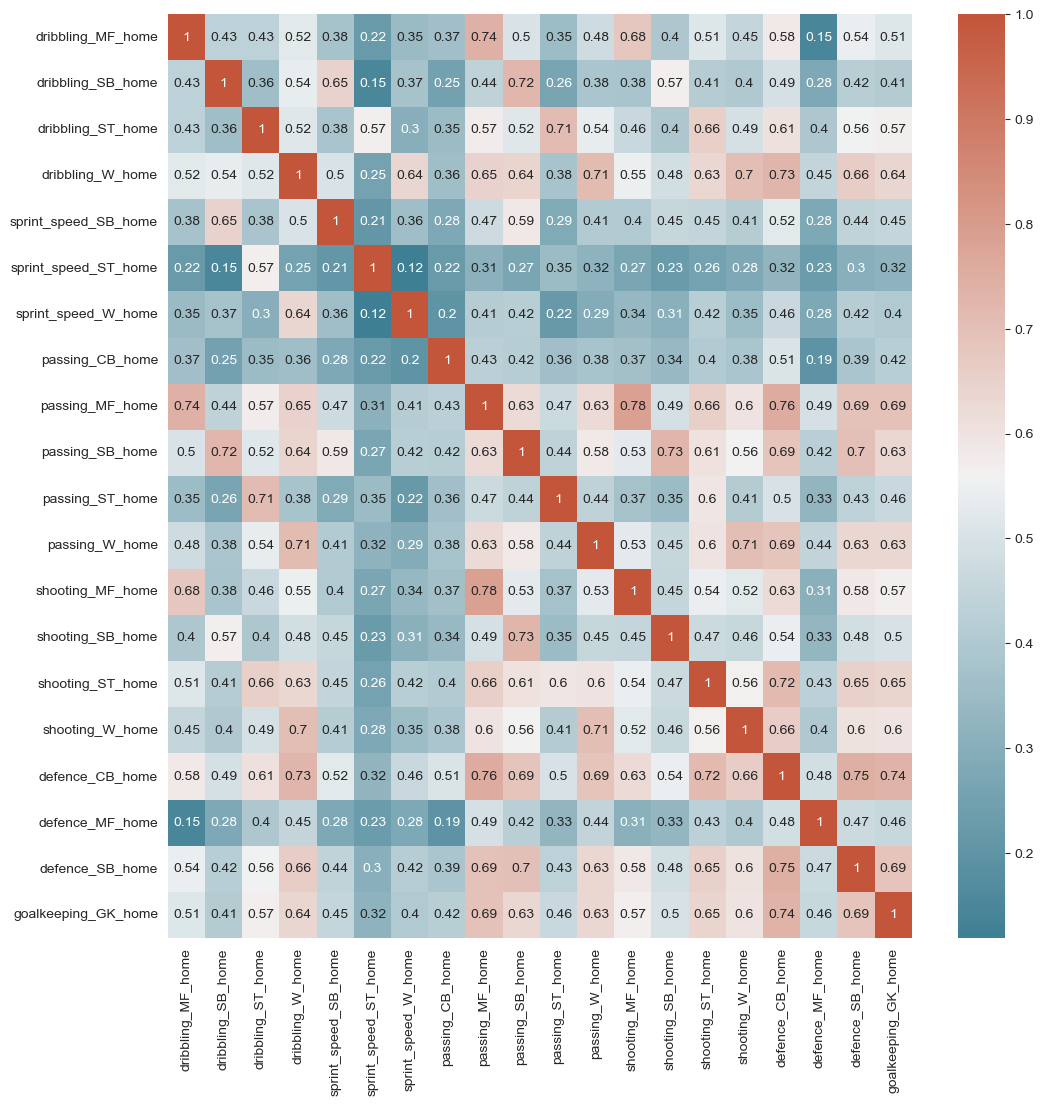

In [22]:
# Plot correlation heatmap
plt.subplots(figsize=(12,12))
sns.heatmap(matches_new.iloc[:, :20].corr(),annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

#### Observations: 
##### - there are constant high correlations between 'passing' and 'dribbling' of one position
Decision: remove 'drbbling' for all positions
##### - there's a high correlation between 'shooting_MF' and 'passing_MF'
Decision: remove 'shooting_MF'
##### - there are constant high correlations between different position which results from unclear reason. 
Decision: ignore

In [23]:
# Drop features
matches_new = matches_new.drop(['dribbling_MF_home', 'dribbling_SB_home', 'dribbling_ST_home',
       'dribbling_W_home', 'dribbling_MF_away', 'dribbling_SB_away', 'dribbling_ST_away', 'dribbling_W_away',
      'shooting_MF_home', 'shooting_MF_away'], axis = 1)

### 3. Quick view on logistic modeling insights using statsmodel

In [24]:
y = matches_new['result']
X = matches_new.drop(['result'], axis = 1)

In [25]:
scaler = MinMaxScaler()
scaler.fit(X)

MinMaxScaler()

In [26]:
X_transformed = scaler.transform(X)
transformed_df = pd.DataFrame(X_transformed, columns = X.columns)
transformed_df['result'] = matches_new['result']

In [27]:
transformed_df.head()

,sprint_speed_SB_home,sprint_speed_ST_home,sprint_speed_W_home,passing_CB_home,passing_MF_home,passing_SB_home,passing_ST_home,passing_W_home,shooting_SB_home,shooting_ST_home,shooting_W_home,defence_CB_home,defence_MF_home,defence_SB_home,goalkeeping_GK_home,sprint_speed_SB_away,sprint_speed_ST_away,sprint_speed_W_away,passing_CB_away,passing_MF_away,passing_SB_away,passing_ST_away,passing_W_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_MF_away,defence_SB_away,goalkeeping_GK_away,result
0,0.713225,0.738024,0.570320,0.607019,0.760402,0.586720,0.612000,0.749090,0.682646,0.691120,0.725217,0.814073,0.711382,0.875342,0.907581,0.697479,0.565868,0.655499,0.462230,0.668426,0.688073,0.454857,0.671074,0.508150,0.669241,0.693086,0.615847,0.765898,0.589583,0.794118,win
1,0.283063,0.618263,0.390498,0.488211,0.462312,0.217707,0.519143,0.565459,0.306807,0.720721,0.597391,0.615105,0.403600,0.515361,0.797677,0.689076,0.655689,0.518266,0.685185,0.384162,0.577982,0.400000,0.440705,0.688399,0.759331,0.554806,0.617349,0.700139,0.574652,0.750000,win
2,0.738529,0.835329,0.693356,0.814111,0.720201,0.866438,0.676286,0.841863,0.813039,0.893179,0.674783,0.779042,0.577816,0.760817,0.912576,0.596639,0.550898,0.598713,0.773927,0.544365,0.562752,0.466714,0.437300,0.408437,0.337194,0.677909,0.668982,0.604673,0.691381,0.813725,win
3,0.063765,0.663174,0.504070,0.460793,0.562814,0.405457,0.581000,0.544758,0.189837,0.701416,0.340870,0.721262,0.257840,0.398906,0.233171,0.756303,0.775449,0.627106,0.489732,0.763249,0.760000,0.500000,0.741186,0.763183,0.680824,0.450253,0.662035,0.736964,0.759247,0.884804,win
4,0.502362,0.520958,0.702820,0.814111,0.494673,0.332189,0.381000,0.656508,0.481304,0.635779,0.735652,0.855930,0.655197,0.332475,0.865118,0.815126,0.820359,0.532463,0.706637,0.704569,0.746239,0.633429,0.527444,0.686481,0.684685,0.672850,0.767555,0.706638,0.727350,0.723039,tie


In [28]:
X_sm = sm.add_constant(X)

label_mapping = {'lose':0, 'tie':0.5, 'win':1}

y_sm = y.map(label_mapping)
log_reg = sm.Logit(y_sm, X_sm).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.602979
         Iterations 5
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.105     
Dependent Variable:  result            AIC:               19740.8101
Date:                2023-06-18 21:50  BIC:               19979.5108
No. Observations:    16318             Log-Likelihood:    -9839.4   
Df Model:            30                LL-Null:           -10999.   
Df Residuals:        16287             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      5.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                 0.0825   0.3251  0.2536 0.7998 -0.5548  0.7197
sprint_speed_SB_home  0.0038

#### Observation: 
##### - defence_MF_home has a negative coef., while defence_MF_away has a positive coef and P = 0.57. 
Decision: remove both 'defence_MF_home' and 'defence_MF_away'

In [29]:
# Drop features
matches_new = matches_new.drop(['defence_MF_home','defence_MF_away'], axis = 1)

In [30]:
y = matches_new['result']
X = matches_new.drop(['result'], axis = 1)
scaler = MinMaxScaler()
scaler.fit(X)

X_transformed = scaler.transform(X)

#Create dataframe for visualization
transformed_df = pd.DataFrame(X_transformed, columns = X.columns)
transformed_df['result'] = matches_new['result']

In [31]:
X_sm = sm.add_constant(X)

label_mapping = {'lose':0, 'tie':0.5, 'win':1}

y_sm = y.map(label_mapping)
log_reg = sm.Logit(y_sm, X_sm).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.603064
         Iterations 5
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.105     
Dependent Variable:  result            AIC:               19739.6070
Date:                2023-06-18 21:50  BIC:               19962.9077
No. Observations:    16318             Log-Likelihood:    -9840.8   
Df Model:            28                LL-Null:           -10999.   
Df Residuals:        16289             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      5.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                 0.0898   0.3247  0.2766 0.7821 -0.5466  0.7262
sprint_speed_SB_home  0.0040

- Now all home team features have positive coef. and all away team features have negative coef.

### 4. Visualizae high dimensional data using PCA

In [32]:
for i in range(2,5):
    pca = PCA(n_components=i)
    X_pca_new = pca.fit_transform(X_transformed)
    print('n_components='+str(i))
    print(pca.explained_variance_ratio_)

n_components=2
[0.39944054 0.12165213]
n_components=3
[0.39944054 0.12165213 0.04636084]
n_components=4
[0.39944054 0.12165213 0.04635478 0.03797015]


In [33]:
pca = PCA(n_components=2)
X_pca_new = pca.fit_transform(X_transformed)

In [34]:
pca_df = pd.DataFrame(X_pca_new, columns = ['PC1', 'PC2'])
pca_df['result'] = y
pca_df.head()

,PC1,PC2,result
0,-0.210024,0.223671,win
1,0.478700,-0.288975,win
2,-0.242427,0.547218,win
3,0.293761,-0.632368,win
4,-0.036950,-0.312667,tie


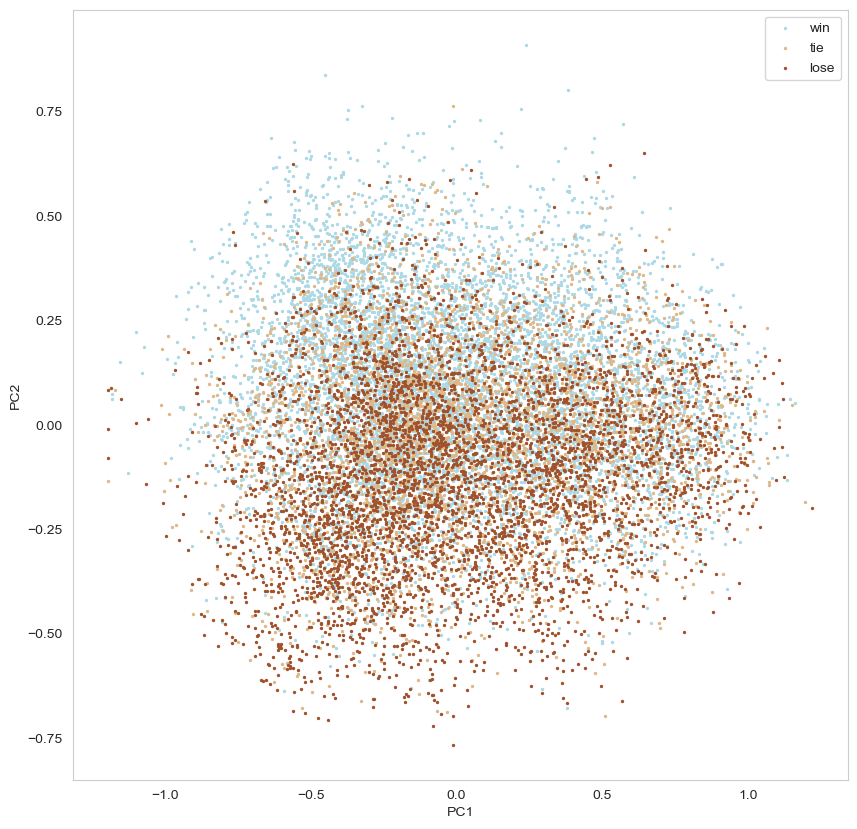

In [35]:
fig, axes = plt.subplots(figsize = (10,10))
results = ['win', 'tie', 'lose']
colors = ['lightblue', 'burlywood', 'sienna']

for result, color in zip(results, colors):
    indicesToKeep = pca_df['result'] == result
    axes.scatter(pca_df.loc[indicesToKeep, 'PC1'],
                 pca_df.loc[indicesToKeep, 'PC2'],
                 c=color,
                 label=result,
                 s=2)

axes.set_xlabel('PC1')
axes.set_ylabel('PC2')
axes.legend()
axes.grid()
plt.show()

- Not ideal, but can observe some patterns

In [36]:
pca_3 = PCA(n_components=3)
X_pca_new_3 = pca_3.fit_transform(X_transformed)
pca_df_3 = pd.DataFrame(X_pca_new_3, columns = ['PC1', 'PC2', 'PC3'])
pca_df_3['result'] = y

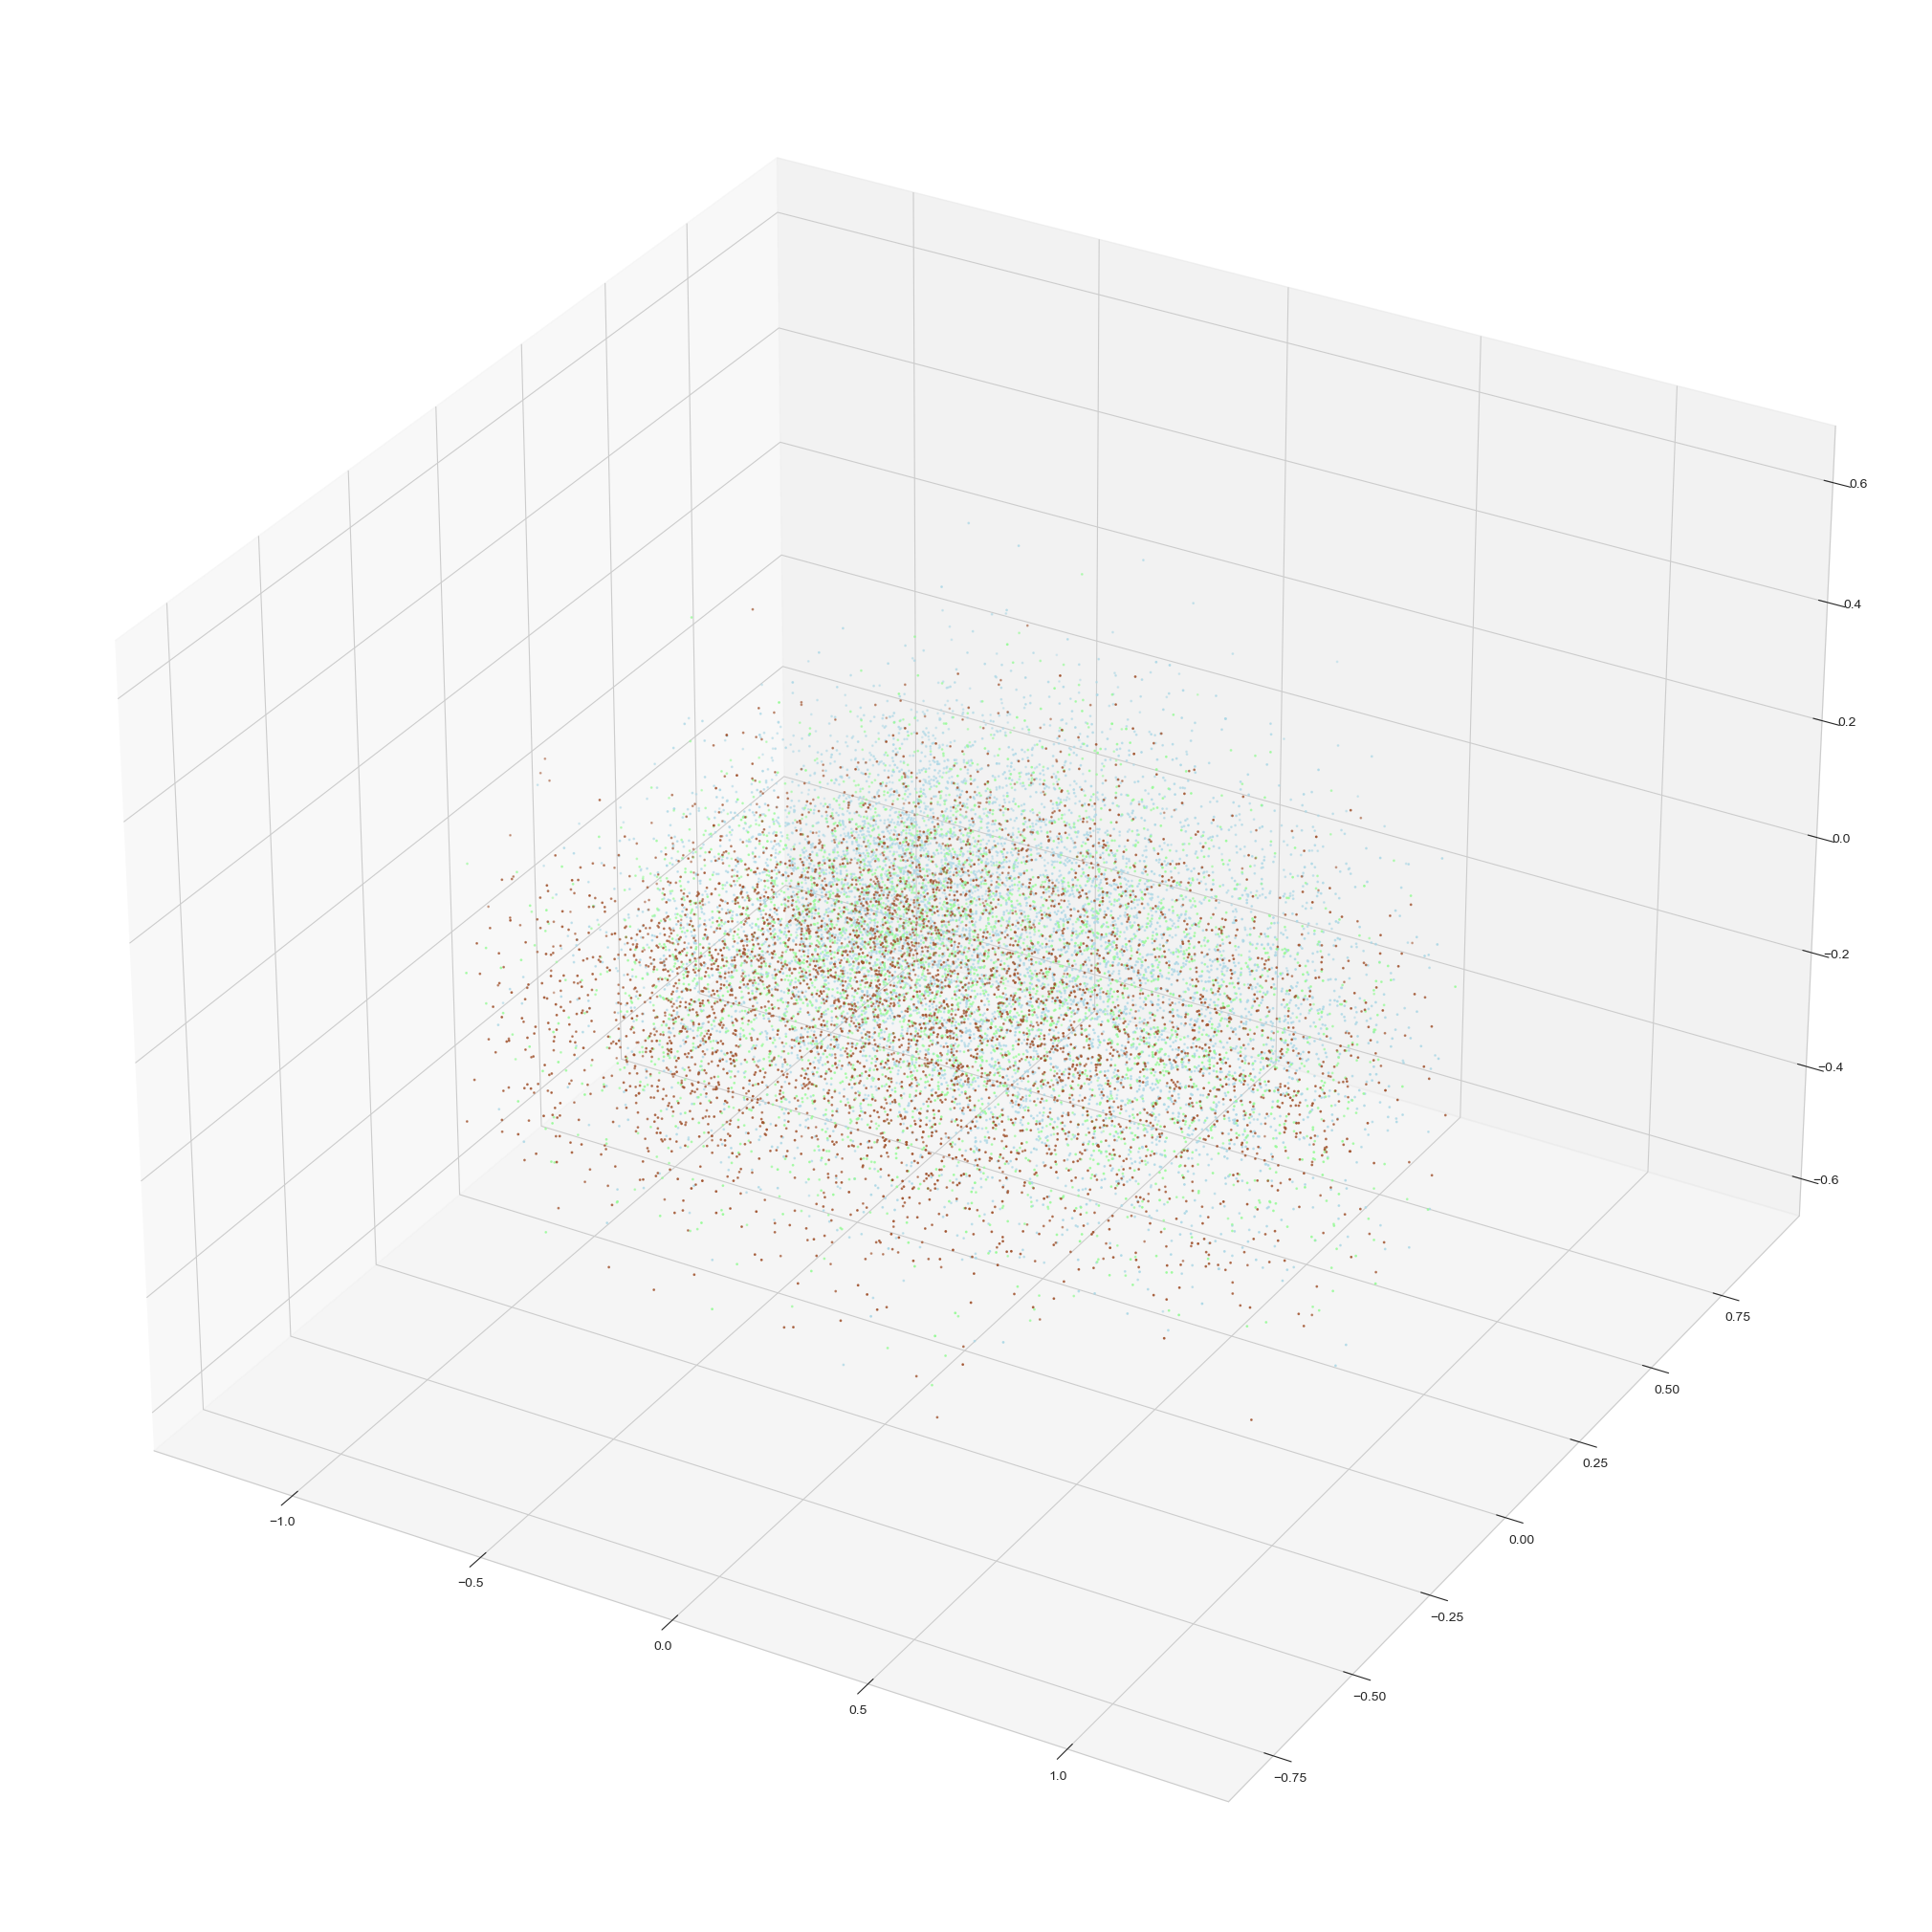

In [37]:
plt.rcParams['figure.figsize'] = (20, 20)
fig = plt.figure()
axes = Axes3D(fig)


results = ['win', 'tie', 'lose']
colors = ['lightblue', 'palegreen', 'sienna']

for result, color in zip(results, colors):
    indicesToKeep = pca_df_3['result'] == result
    axes.scatter(pca_df_3.loc[indicesToKeep, 'PC1'],
                 pca_df_3.loc[indicesToKeep, 'PC2'],
                 pca_df_3.loc[indicesToKeep, 'PC3'],
                 c=color,
                 label=result,
                 s=1)
plt.show()

- Not ideal, but can observe some patterns

In [38]:
# Save final dataframe
matches_new.to_csv('../dataset/matches_final.csv', index = False)